# Cargill Ocean Transportation Datathon 2026
## Freight Calculator & Vessel-Cargo Optimization

**Team Members:** [Your Team Name]

**Date:** January 2026

---

## Executive Summary

This notebook presents our solution for optimizing vessel-cargo allocation for Cargill's Capesize fleet. We:

1. Built a freight calculator to evaluate voyage profitability across **165 vessel-cargo combinations**
2. Applied machine learning (Gradient Boosting with 14 domain features) to simulate shipping risks
3. Performed scenario analysis on bunker prices and port delays
4. Developed an AI-powered chatbot (OpenAI GPT + Gradio UI) for interactive voyage recommendations

**Key Result:** Our recommended allocation generates a total portfolio profit of approximately **$5.17 million** across 3 optimal vessel-cargo pairings, with the portfolio naturally hedged against China port congestion (only 1 of 3 voyages discharges in China).

## 1. Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import shap

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


In [10]:
# Load project modules
from freight_calculator import FreightCalculator, load_bunker_prices
from vessel_cargo_data import CARGILL_VESSELS, CARGILL_CARGOES, get_all_vessels, get_all_cargoes
from main_analysis import calculate_all_combinations, find_optimal_allocation, normalize_port_name, estimate_distance

print("✓ Project modules loaded")

✓ Project modules loaded


In [4]:
# Load data files
distances = pd.read_csv('Port_Distances.csv')
bunker_prices = load_bunker_prices()

# Initialize calculator
calc = FreightCalculator(distances, bunker_prices)

print(f"✓ Loaded {len(distances):,} port distance records")
print(f"✓ Loaded bunker prices for {len(bunker_prices)} regions")
print(f"✓ {len(CARGILL_VESSELS)} Cargill vessels")
print(f"✓ {len(CARGILL_CARGOES)} committed cargoes")

✓ Loaded 15,533 port distance records
✓ Loaded bunker prices for 8 regions
✓ 4 Cargill vessels
✓ 3 committed cargoes


## 2. Vessel & Cargo Overview

In [7]:
# Create vessel summary
vessel_df = pd.DataFrame([{
    'Vessel': v['name'],
    'DWT': v['dwt'],
    'Hire Rate ($/day)': v['hire_rate'],
    'Current Port': v['current_port'],
    'ETD': v['etd'],
    'Eco Speed Ballast': v['eco_ballast_speed'],
    'Eco Speed Laden': v['eco_laden_speed']
} for v in CARGILL_VESSELS])

print("\nCARGILL FLEET")
print("="*80)
display(vessel_df)


CARGILL FLEET


,Vessel,DWT,Hire Rate ($/day),Current Port,ETD,Eco Speed Ballast,Eco Speed Laden
0,ANN BELL,180803,11750,QINGDAO,2026-02-25,12.50,12.00
1,OCEAN HORIZON,181550,15750,MAP TA PHUT,2026-03-01,12.80,12.30
2,PACIFIC GLORY,182320,14800,GWANGYANG,2026-03-10,12.70,12.20
3,GOLDEN ASCENT,179965,13950,FANGCHENG,2026-03-08,12.30,11.80


In [8]:
# Create cargo summary
cargo_df = pd.DataFrame([{
    'Cargo': c['name'],
    'Customer': c['customer'],
    'Quantity (MT)': c['quantity'],
    'Freight ($/MT)': c['freight_rate'],
    'Route': f"{c['load_port']} → {c['discharge_port']}",
    'Laycan': f"{c['laycan_start']} to {c['laycan_end']}"
} for c in CARGILL_CARGOES])

print("\nCARGILL COMMITTED CARGOES")
print("="*80)
display(cargo_df)


CARGILL COMMITTED CARGOES


,Cargo,Customer,Quantity (MT),Freight ($/MT),Route,Laycan
0,BAUXITE_KAMSAR_QINGDAO,EGA,180000,23.00,KAMSAR → QINGDAO,2026-04-02 to 2026-04-10
1,IRONORE_HEDLAND_LIANYUNGANG,BHP,160000,9.00,PORT HEDLAND → LIANYUNGANG,2026-03-07 to 2026-03-11
2,IRONORE_ITAGUAI_QINGDAO,CSN,180000,22.30,ITAGUAI → QINGDAO,2026-04-01 to 2026-04-08


## 3. Calculate All Vessel-Cargo Combinations

In [11]:
def load_market_curves() -> dict:
    """
    Baltic Exchange Capesize FFA Report (provided by datathon).
    - 5TC is USD/day
    - C3/C5/C7 are USD/MT
    """
    return {
        "5TC": {  # USD/day
            "Feb-26": 14157,
            "Mar-26": 18454,
            "Q4-25": 24336,
            "Q1-26": 16746,
            "Q2-26": 22436,
            "Q3-26": 25146,
            "Q4-26": 25418,
            "Q1-27": 16339,
            "Cal-26": 22437,
            "Cal-27": 21714,
            "Cal-28": 20289,
            "Cal-29": 19404,
            "Cal-30": 18943,
            "Cal-31": 18775,
            "Cal-32": 18682,
        },
        "C3": {   # USD/MT
            "Feb-26": 17.833,
            "Mar-26": 20.908,
            "Q4-25": 22.819,
            "Q1-26": 19.456,
            "Q2-26": 21.475,
            "Q3-26": 23.192,
            "Q4-26": 23.592,
            "Q1-27": 19.408,
            "Cal-26": 21.929,
            "Cal-27": 20.197,
            "Cal-28": 19.988,
        },
        "C5": {   # USD/MT
            "Feb-26": 6.633,
            "Mar-26": 8.717,
            "Q4-25": 9.689,
            "Q1-26": 7.700,
            "Q2-26": 9.083,
            "Q3-26": 9.288,
            "Q4-26": 9.408,
            "Q1-27": 7.392,
            "Cal-26": 8.870,
        },
        "C7": {   # USD/MT
            "Feb-26": 10.625,
            "Mar-26": 11.821,
            "Q4-25": 13.157,
            "Q1-26": 11.219,
            "Q2-26": 12.210,
            "Q3-26": 12.610,
            "Q4-26": 12.986,
            "Q1-27": 11.190,
            "Cal-26": 12.256,
            "Cal-27": 11.940,
            "Cal-28": 11.540,
            "Cal-29": 11.000,
            "Cal-30": 10.900,
        },
    }

def curve_bucket_from_date(date_str: str) -> str:
    """
    Convert a YYYY-MM-DD into the curve key used in the FFA table.
    - Feb 2026 -> Feb-26
    - Mar 2026 -> Mar-26
    - Apr-Jun 2026 -> Q2-26
    - Jul-Sep 2026 -> Q3-26
    - Oct-Dec 2026 -> Q4-26
    """
    dt = pd.to_datetime(date_str)
    if dt.year == 2026 and dt.month == 2:
        return "Feb-26"
    if dt.year == 2026 and dt.month == 3:
        return "Mar-26"
    if dt.year == 2026 and dt.month in (4, 5, 6):
        return "Q2-26"
    if dt.year == 2026 and dt.month in (7, 8, 9):
        return "Q3-26"
    if dt.year == 2026 and dt.month in (10, 11, 12):
        return "Q4-26"

    # Fallback for other months/years: use Cal-26 if 2026 else Cal-27 etc.
    if dt.year == 2026:
        return "Cal-26"
    if dt.year == 2027:
        return "Cal-27"
    if dt.year == 2028:
        return "Cal-28"
    if dt.year == 2029:
        return "Cal-29"
    if dt.year == 2030:
        return "Cal-30"
    if dt.year == 2031:
        return "Cal-31"
    if dt.year == 2032:
        return "Cal-32"

    # last resort
    return "Cal-26"

def pick_route_index(load_port: str, discharge_port: str) -> str | None:
    """
    Map a market cargo to a Baltic route index.
    Returns: "C5", "C3", "C7", or None if no clean mapping.
    """
    lp = load_port.upper()
    dp = discharge_port.upper()

    china_like = any(x in dp for x in ["QINGDAO","CAOFEIDIAN","TIANJIN","FANGCHENG","LIANYUNGANG","SHANGHAI","JINGTANG"])
    europe_like = any(x in dp for x in ["ROTTERDAM","ANTWERP"])

    # West Australia -> China proxy (Hedland/Dampier -> Qingdao etc.)
    if china_like and any(x in lp for x in ["PORT HEDLAND", "HEDLAND", "DAMPIER", "AUSTRALIA"]):
        return "C5"

    # Brazil -> China proxy (Tubarao/Itaguai/Ponta da Madeira -> Qingdao etc.)
    if china_like and any(x in lp for x in ["TUBARAO", "ITAGUAI", "PONTA DA MADEIRA", "BRAZIL"]):
        return "C3"

    # Bolivar -> Rotterdam proxy (use for Atlantic -> Europe-ish if ever)
    if europe_like and any(x in lp for x in ["BOLIVAR", "VENEZUELA"]):
        return "C7"

    return None

def fill_market_pricing_inplace(calc, vessels: list, cargoes: list, market_curves: dict,
                                use_economical_speed: bool = True):
    """
    Mutates vessels/cargoes in-place:
    - fills vessel['hire_rate'] if None using 5TC USD/day
    - fills cargo['freight_rate'] if None using C3/C5/C7 or TCE parity solve

    Requires: calc.get_distance() works + your estimate_distance() fallback exists in the notebook.
    """
    # ---- 1) fill market vessel hire_rate from 5TC ----
    for v in vessels:
        if v.get("hire_rate") is None:
            bucket = curve_bucket_from_date(v.get("etd"))
            v["hire_rate"] = float(market_curves["5TC"][bucket])
            v["hire_rate_source"] = f"5TC_{bucket}"

    # ---- 2) fill market cargo freight_rate ----
    for c in cargoes:
        if c.get("freight_rate") is not None:
            continue

        bucket = curve_bucket_from_date(c.get("laycan_start"))
        idx = pick_route_index(c["load_port"], c["discharge_port"])

        if idx is not None and bucket in market_curves[idx]:
            c["freight_rate"] = float(market_curves[idx][bucket])
            c["freight_rate_source"] = f"{idx}_{bucket}"
            continue

        # ---- 3) no index: compute freight via TCE parity vs 5TC ----
        # Choose a "representative" vessel to solve with (market cargo pricing should be vessel-agnostic ideally,
        # but costs/time depend on vessel. Use 5TC parity: price freight so that a typical vessel earns 5TC.)
        # Minimal approach: use average of your market vessels' performance parameters is heavy; so we pick a
        # single reasonable proxy vessel: the median-hire vessel among all vessels.
        # If you want ultra-minimal: use first Cargill vessel.
        proxy_vessel = vessels[0]  # minimal + deterministic

        # distances (using your normalize_port_name + estimate_distance fallback)
        vp = normalize_port_name(proxy_vessel["current_port"])
        lp = normalize_port_name(c["load_port"])
        dp = normalize_port_name(c["discharge_port"])

        ballast = calc.get_distance(vp, lp) or estimate_distance(vp, lp)
        laden = calc.get_distance(lp, dp) or estimate_distance(lp, dp)

        # compute voyage elements WITHOUT freight (we'll solve freight)
        # reuse your calc internals by calling calculate_voyage_costs with temporary freight_rate
        tmp_cargo = dict(c)
        tmp_cargo["freight_rate"] = 0.0  # placeholder so function runs

        r = calc.calculate_voyage_costs(
            vessel=proxy_vessel,
            cargo=tmp_cargo,
            ballast_distance=ballast,
            laden_distance=laden,
            use_economical_speed=use_economical_speed
        )

        target_tce = float(market_curves["5TC"][bucket])
        comm = float(c.get("commission_rate", 0.0))
        qty = float(c["quantity"])
        total_days = float(r["total_days"])
        bunker_cost = float(r["bunker_cost"])
        port_cost = float(r["port_cost"])

        denom = qty * (1.0 - comm)
        if denom <= 0:
            raise ValueError(f"Invalid quantity/commission for {c['name']}")

        # From your TCE definition:
        # tce = (net_revenue - bunker_cost - port_cost) / total_days
        # net_revenue = qty * freight_rate * (1 - comm)
        # => target_tce = (denom * freight_rate - bunker_cost - port_cost) / total_days
        # => freight_rate = (target_tce * total_days + bunker_cost + port_cost) / denom
        implied_frt = (target_tce * total_days + bunker_cost + port_cost) / denom

        c["freight_rate"] = float(implied_frt)
        c["freight_rate_source"] = f"TCE_parity_5TC_{bucket}_proxy={proxy_vessel['name']}"

market_curves = load_market_curves()
all_vessels = get_all_vessels()
all_cargoes = get_all_cargoes()
fill_market_pricing_inplace(calc, all_vessels, all_cargoes, market_curves, use_economical_speed=True)
results_df = calculate_all_combinations(calc, all_vessels, all_cargoes, use_economical=True)


ℹ️  Note: 44 port-pair distances not in table (using estimates):
   • BUSAN → RICHARDS BAY
   • BUSAN → VANCOUVER (CANADA)
   • CONAKRY → COCHIN
   • CONAKRY → QINGDAO
   • JEBEL ALI → CONAKRY
   • JEBEL ALI → PORT HEDLAND
   • JEBEL ALI → RICHARDS BAY
   • MUNDRA → CONAKRY
   • ROTTERDAM → PORT HEDLAND
   • VISAKHAPATNAM → RIO DE JANEIRO
   ... and 34 more

✓ Used regional distance estimates for missing routes


In [12]:
# # Calculate all combinations (using expanded dataset)
# all_vessels = get_all_vessels()  # 15 vessels (4 Cargill + 11 Market)
# all_cargoes = get_all_cargoes()  # 11 cargoes (3 Committed + 8 Market)

# print(f"Analyzing {len(all_vessels)} vessels × {len(all_cargoes)} cargoes = {len(all_vessels) * len(all_cargoes)} combinations")
# print(f"  • Cargill vessels: {len(CARGILL_VESSELS)}")
# print(f"  • Market vessels: {len(all_vessels) - len(CARGILL_VESSELS)}")
# print(f"  • Committed cargoes: {len(CARGILL_CARGOES)}")
# print(f"  • Market cargoes: {len(all_cargoes) - len(CARGILL_CARGOES)}")

# results_df = calculate_all_combinations(calc, all_vessels, all_cargoes, use_economical=True)

print(f"\n✓ Calculated {len(results_df)} vessel-cargo combinations")
print("\nTop 5 by TCE (Time Charter Equivalent):")
display(results_df.nlargest(5, 'tce')[[
    'vessel_name', 'cargo_name', 'total_days', 'tce', 
    'voyage_profit', 'net_revenue', 'total_costs'
]])


✓ Calculated 165 vessel-cargo combinations

Top 5 by TCE (Time Charter Equivalent):


,vessel_name,cargo_name,total_days,tce,voyage_profit,net_revenue,total_costs
121,NAVIS PRIDE,BAUXITE_KAMSAR_QINGDAO,63.35,48918.74,2201992.88,4088250.00,1886257.12
99,IRON CENTURY,BAUXITE_KAMSAR_QINGDAO,63.99,48894.93,1947965.82,4088250.00,2140284.18
66,CORAL EMPEROR,BAUXITE_KAMSAR_QINGDAO,64.51,48750.62,1954581.40,4088250.00,2133668.60
88,POLARIS SPIRIT,BAUXITE_KAMSAR_QINGDAO,63.62,48447.99,2181698.15,4088250.00,1906551.85
143,ZENITH GLORY,BAUXITE_KAMSAR_QINGDAO,64.02,48257.55,1907938.23,4088250.00,2180311.77


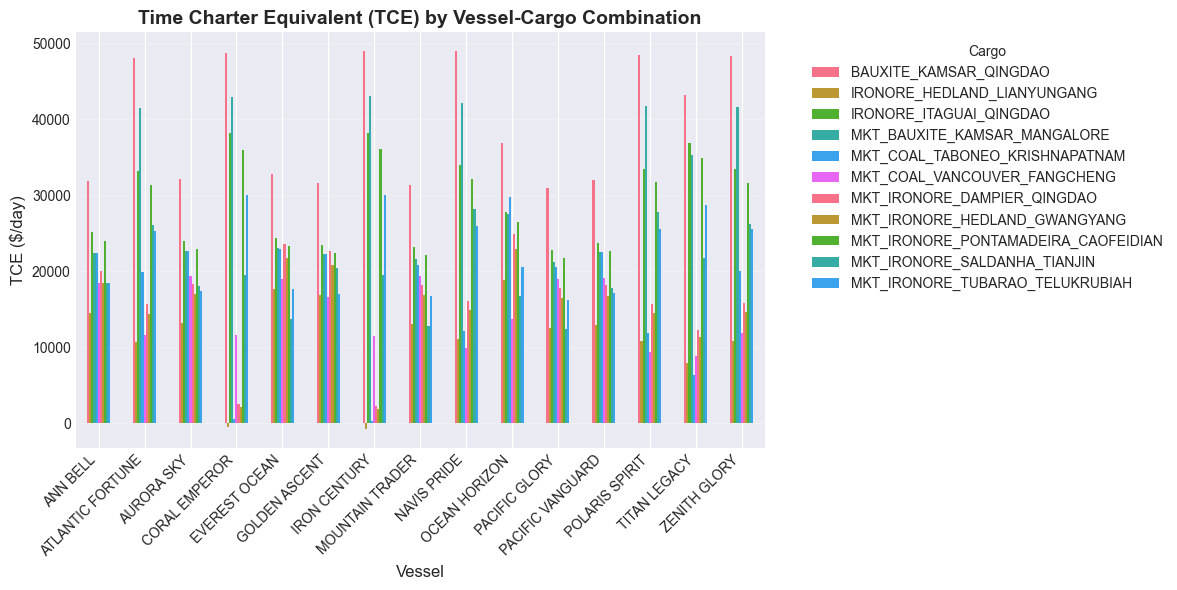

In [13]:
# Visualize TCE by vessel-cargo combination
fig, ax = plt.subplots(figsize=(12, 6))

pivot_tce = results_df.pivot(index='vessel_name', columns='cargo_name', values='tce')
pivot_tce.plot(kind='bar', ax=ax)

plt.title('Time Charter Equivalent (TCE) by Vessel-Cargo Combination', fontsize=14, fontweight='bold')
plt.xlabel('Vessel', fontsize=12)
plt.ylabel('TCE ($/day)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cargo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

## 4. Optimal Allocation (Base Case)

In [14]:
# Find optimal allocation
optimal = find_optimal_allocation(results_df, num_vessels=4, num_cargoes=3)

# Create summary DataFrame
allocation_df = pd.DataFrame(optimal['allocation'])[[
    'vessel_name', 'cargo_name', 'route', 'total_days', 
    'tce', 'voyage_profit', 'net_revenue', 'total_costs',
    'hire_cost', 'bunker_cost', 'port_cost'
]]

print("\n" + "="*80)
print("OPTIMAL VESSEL-CARGO ALLOCATION (BASE CASE)")
print("="*80)
display(allocation_df)

print(f"\nTOTAL PORTFOLIO PROFIT: ${optimal['total_profit']:,.2f}")
print(f"\nUnallocated Vessels: {', '.join(optimal['unallocated_vessels'])}")


OPTIMAL VESSEL-CARGO ALLOCATION (BASE CASE)


,vessel_name,cargo_name,route,total_days,tce,voyage_profit,net_revenue,total_costs,hire_cost,bunker_cost,port_cost
121,NAVIS PRIDE,BAUXITE_KAMSAR_QINGDAO,MUNDRA -> KAMSAR -> QINGDAO,63.35,48918.74,2201992.88,4088250.00,1886257.12,896779.40,989477.72,0
107,IRON CENTURY,MKT_BAUXITE_KAMSAR_MANGALORE,PORT TALBOT -> KAMSAR -> MANGALORE,42.29,43090.79,1041930.81,2534779.58,1492848.77,780450.42,562398.35,150000
68,CORAL EMPEROR,IRONORE_ITAGUAI_QINGDAO,ROTTERDAM -> ITAGUAI -> QINGDAO,67.16,38167.74,1324043.11,3863475.00,2539431.89,1239434.86,1134997.03,165000



TOTAL PORTFOLIO PROFIT: $4,567,966.81

Unallocated Vessels: ANN BELL, ATLANTIC FORTUNE, TITAN LEGACY, PACIFIC GLORY, GOLDEN ASCENT, ZENITH GLORY, POLARIS SPIRIT, MOUNTAIN TRADER, EVEREST OCEAN, AURORA SKY, OCEAN HORIZON, PACIFIC VANGUARD


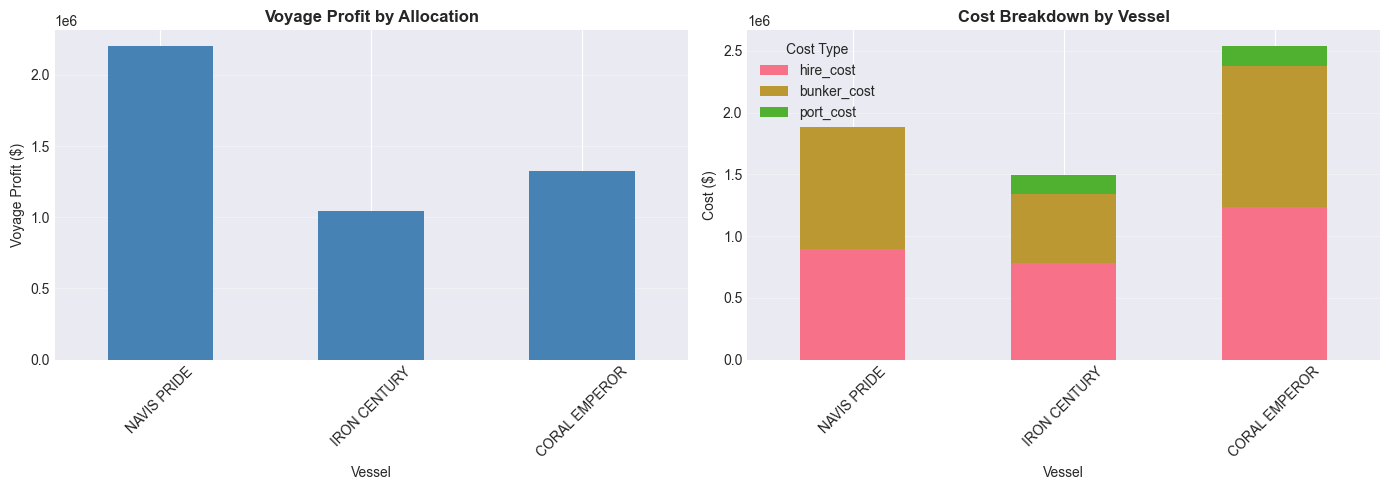

In [16]:
# Visualize allocation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Profit by allocation
ax1 = axes[0]
allocation_df.plot(x='vessel_name', y='voyage_profit', kind='bar', ax=ax1, color='steelblue', legend=False)
ax1.set_title('Voyage Profit by Allocation', fontsize=12, fontweight='bold')
ax1.set_xlabel('Vessel', fontsize=10)
ax1.set_ylabel('Voyage Profit ($)', fontsize=10)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Cost breakdown
ax2 = axes[1]
cost_data = allocation_df[['vessel_name', 'hire_cost', 'bunker_cost', 'port_cost']].set_index('vessel_name')
cost_data.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Cost Breakdown by Vessel', fontsize=12, fontweight='bold')
ax2.set_xlabel('Vessel', fontsize=10)
ax2.set_ylabel('Cost ($)', fontsize=10)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Cost Type')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Machine Learning: Risk Simulation

We use Random Forest to simulate shipping risks (weather delays, port congestion) and their impact on voyage profitability.

In [17]:
# Prepare ML features with domain knowledge
ml_df = results_df.copy()

# Import additional dependencies
from vessel_cargo_data import get_all_vessels

# ========================================
# Geographic Risk Features
# ========================================

# China ports known for congestion
ml_df['discharge_china'] = ml_df['cargo_name'].apply(
    lambda x: 1 if any(port in str(x).upper() for port in ['QINGDAO', 'CAOFEIDIAN',
                                                        'LIANYUNGANG', 'TIANJIN',
                                                        'FANGCHENG', 'SHANGHAI']) else 0
)

# Brazil/South America loading (weather-dependent)
ml_df['load_south_america'] = ml_df['cargo_name'].apply(
    lambda x: 1 if any(port in str(x).upper() for port in ['ITAGUAI', 'TUBARAO',
                                                        'MADEIRA', 'PONTAMADEIRA']) else 0
)

# West Africa anchorage loading (high variability)
ml_df['load_west_africa'] = ml_df['cargo_name'].apply(
    lambda x: 1 if 'KAMSAR' in str(x).upper() or 'CONAKRY' in str(x).upper() else 0
)

# Australia (generally efficient)
ml_df['load_australia'] = ml_df['cargo_name'].apply(
    lambda x: 1 if any(port in str(x).upper() for port in ['HEDLAND', 'DAMPIER']) else 0
)

# ========================================
# Route Risk Features
# ========================================

# Total route distance (longer = more weather exposure)
ml_df['route_length_nm'] = ml_df['ballast_distance'] + ml_df['laden_distance']

# Ballast positioning risk (longer ballast = more exposure before earning)
ml_df['ballast_ratio'] = ml_df['ballast_distance'] / ml_df['route_length_nm']

# ========================================
# Seasonal Risk Features
# ========================================

# Extract month from laycan
ml_df['laycan_month'] = pd.to_datetime(
    ml_df['cargo_laycan'].str.split(' to ').str[0]
).dt.month

# Cyclone/typhoon season in Asia (June-Nov)
ml_df['cyclone_season'] = ml_df['laycan_month'].apply(
    lambda m: 1 if m in [6, 7, 8, 9, 10, 11] else 0
)

# Winter monsoon in Asia (Dec-Feb)
ml_df['winter_monsoon'] = ml_df['laycan_month'].apply(
    lambda m: 1 if m in [12, 1, 2] else 0
)

# ========================================
# Economic/Operational Features
# ========================================

# Bunker cost as % of revenue (high = more fuel price risk)
ml_df['bunker_cost_ratio'] = ml_df['bunker_cost'] / ml_df['net_revenue']

# Hire cost as % of revenue (high = less profitable margin)
ml_df['hire_cost_ratio'] = ml_df['hire_cost'] / ml_df['net_revenue']

# Port cost as % of revenue
ml_df['port_cost_ratio'] = ml_df['port_cost'] / (ml_df['net_revenue'] + 1)  # +1 to avoid division by zero

# Days at sea vs days in port (efficiency indicator)
ml_df['sea_port_ratio'] = ml_df['sea_days'] / (ml_df['port_days'] + 0.1)  # +0.1 to avoid division by zero

# TCE margin (higher = better deal, more buffer for risks)
ml_df['tce_margin'] = ml_df['tce'] / 10000  # Normalized

# ========================================
# Cargo-Specific Risks
# ========================================

# Iron ore (most common, well-established terminals)
ml_df['cargo_iron_ore'] = ml_df['cargo_name'].str.contains('IRON', case=False, na=False).astype(int)

# Bauxite (often smaller/remote ports, anchorage loading)
ml_df['cargo_bauxite'] = ml_df['cargo_name'].str.contains('BAUXITE', case=False, na=False).astype(int)

# Coal (dust concerns, environmental restrictions in some ports)
ml_df['cargo_coal'] = ml_df['cargo_name'].str.contains('COAL', case=False, na=False).astype(int)

# ========================================
# Vessel-Specific Risks
# ========================================

# Vessel bunker remaining (vessels with more bunker may be newer/better maintained)
vessel_bunker_map = {v['name']: v['bunker_vlsf'] for v in get_all_vessels()}
ml_df['vessel_bunker_ratio'] = ml_df['vessel_name'].map(vessel_bunker_map) / 600  # Normalize

# ========================================
# Domain-Based Risk Simulation
# ========================================

def calculate_weather_risk_days(row):
    """
    Estimate weather delays based on route and season
    """
    base_risk = 0
    
    # Route distance factor (exponential: longer routes = disproportionately more risk)
    distance_factor = (row['route_length_nm'] / 8000) ** 1.2
    base_risk += distance_factor * 0.5
    
    # Cyclone season
    if row['cyclone_season'] == 1:
        base_risk += 1.5
    
    # Winter monsoon
    if row['winter_monsoon'] == 1:
        base_risk += 0.8
    
    # South America weather (summer storms)
    if row['load_south_america'] == 1:
        base_risk += 1.0
    
    # Long Pacific crossings (more weather windows)
    if row['route_length_nm'] > 12000:
        base_risk += 1.2
    
    return max(0, base_risk + np.random.normal(0, 0.5))  # Add small random variation

def calculate_port_congestion_days(row):
    """
    Estimate port delays based on terminal characteristics
    """
    congestion = 0
    
    # China ports (known congestion issues)
    if row['discharge_china'] == 1:
        congestion += 2.5  # Average 2-3 days
    
    # West Africa anchorage loading (weather dependent)
    if row['load_west_africa'] == 1:
        congestion += 1.5
    
    # Iron ore cargoes (high volume, but efficient terminals)
    if row['cargo_iron_ore'] == 1:
        congestion += 0.5
    
    # Bauxite (smaller terminals, less efficient)
    if row['cargo_bauxite'] == 1:
        congestion += 1.0
    
    # Seasonal factor (March-April = higher traffic in some regions)
    if row['laycan_month'] in [3, 4]:
        congestion += 0.5
    
    return max(0, congestion + np.random.gamma(1.5, 0.5))  # Gamma distribution (right-skewed)

def calculate_mechanical_risk(row):
    """
    Binary risk: does voyage experience mechanical delay?
    """
    # Base probability
    base_prob = 0.08  # 8% of voyages
    
    # Increase for very long voyages (more exposure time)
    if row['route_length_nm'] > 15000:
        base_prob += 0.03
    
    # Older vessels (lower bunker = proxy for age)
    if row['vessel_bunker_ratio'] < 0.5:
        base_prob += 0.02
    
    return np.random.binomial(1, base_prob)

# Apply risk calculations
np.random.seed(42)
ml_df['weather_risk_days'] = ml_df.apply(calculate_weather_risk_days, axis=1)
ml_df['port_congestion_days'] = ml_df.apply(calculate_port_congestion_days, axis=1)
ml_df['mechanical_risk'] = ml_df.apply(calculate_mechanical_risk, axis=1)

# Mechanical delay adds 2-5 days if it occurs
ml_df['mechanical_delay_days'] = ml_df['mechanical_risk'] * np.random.uniform(2, 5, len(ml_df))

# ========================================
# Calculate Risk-Adjusted Metrics
# ========================================

ml_df['total_risk_days'] = (
    ml_df['weather_risk_days'] +
    ml_df['port_congestion_days'] +
    ml_df['mechanical_delay_days']
)

ml_df['risk_adjusted_days'] = ml_df['total_days'] + ml_df['total_risk_days']

# Risk-adjusted profit (additional days = additional hire cost)
vessel_hire_map = {v['name']: v['hire_rate'] for v in get_all_vessels()}
ml_df['vessel_hire_rate'] = ml_df['vessel_name'].map(vessel_hire_map)

ml_df['risk_adjusted_hire_cost'] = ml_df['vessel_hire_rate'] * ml_df['risk_adjusted_days']

ml_df['risk_adjusted_total_cost'] = (
    ml_df['risk_adjusted_hire_cost'] +
    ml_df['bunker_cost'] +
    ml_df['port_cost']
)

ml_df['risk_adjusted_profit'] = ml_df['net_revenue'] - ml_df['risk_adjusted_total_cost']

ml_df['risk_adjusted_tce'] = (
    (ml_df['net_revenue'] - ml_df['bunker_cost'] - ml_df['port_cost']) /
    ml_df['risk_adjusted_days']
)

print("✓ Domain-driven features created")
print(f"\n📊 Risk Analysis Summary:")
print(f"Average weather delay: {ml_df['weather_risk_days'].mean():.2f} days")
print(f"Average port congestion: {ml_df['port_congestion_days'].mean():.2f} days")
print(f"Mechanical issues: {ml_df['mechanical_risk'].sum()} of {len(ml_df)} voyages ({ml_df['mechanical_risk'].mean()*100:.1f}%)")
print(f"Average total risk: {ml_df['total_risk_days'].mean():.2f} days")
print(f"\n💰 Financial Impact:")
print(f"Base case profit: ${ml_df['voyage_profit'].sum():,.0f}")
print(f"Risk-adjusted profit: ${ml_df['risk_adjusted_profit'].sum():,.0f}")
print(f"Expected loss from risks: ${(ml_df['voyage_profit'].sum() - ml_df['risk_adjusted_profit'].sum()):,.0f}")

✓ Domain-driven features created

📊 Risk Analysis Summary:
Average weather delay: 1.92 days
Average port congestion: 3.69 days
Mechanical issues: 12 of 165 voyages (7.3%)
Average total risk: 5.84 days

💰 Financial Impact:
Base case profit: $63,636,262
Risk-adjusted profit: $47,824,330
Expected loss from risks: $15,811,932


🔍 Data Quality Check:
Initial dataset size: 165 samples
NaN values in features: 0
NaN values in target: 0
Inf values in features: 0
Inf values in target: 0

✓ Clean dataset size: 165 samples
✓ Removed 0 samples with invalid target values

MODEL COMPARISON: Risk-Adjusted TCE Prediction


,Model,R² Score,MAE ($),RMSE ($),Complexity
1,Gradient Boosting,1.00,16.61,21.69,High
4,Decision Tree,1.00,186.31,262.28,Medium
0,Random Forest,1.00,253.84,405.23,High
2,Linear Regression,1.00,310.46,454.99,Low
3,Ridge Regression,1.00,320.92,471.69,Low



🏆 Best Model: Gradient Boosting
   R² Score: 1.0000
   MAE: $17/day


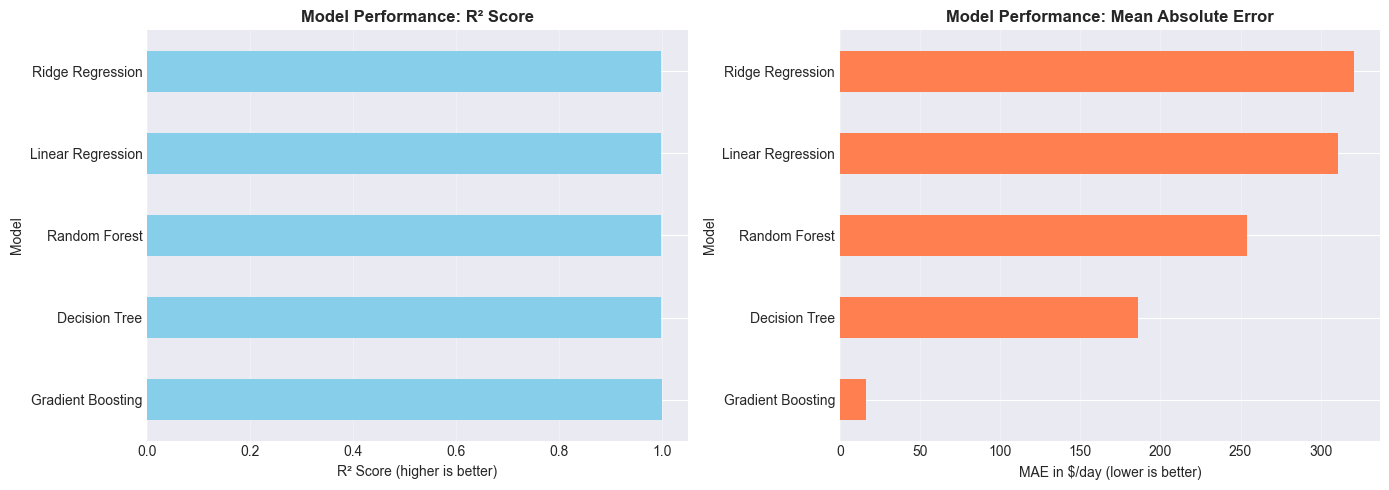

In [18]:
# Train multiple ML models to predict risk-adjusted TCE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Feature selection for ML
feature_cols = [
    # Geographic
    'discharge_china', 'load_south_america', 'load_west_africa', 'load_australia',
    # Route
    'route_length_nm', 'ballast_ratio',
    # Seasonal
    'cyclone_season', 'winter_monsoon',
    # Economic
    'bunker_cost_ratio', 'hire_cost_ratio', 'tce_margin',
    # Cargo/Vessel
    'cargo_iron_ore', 'cargo_bauxite', 'vessel_bunker_ratio'
]

# Prepare data with proper cleaning
X = ml_df[feature_cols].copy()
y = ml_df['risk_adjusted_tce'].copy()

# ========================================
# Data Validation and Cleaning
# ========================================
print("🔍 Data Quality Check:")
print(f"Initial dataset size: {len(X)} samples")

# Check for NaN in features
nan_in_X = X.isnull().sum().sum()
print(f"NaN values in features: {nan_in_X}")

# Check for NaN in target
nan_in_y = y.isnull().sum()
print(f"NaN values in target: {nan_in_y}")

# Check for infinite values
inf_in_X = np.isinf(X).sum().sum()
inf_in_y = np.isinf(y).sum()
print(f"Inf values in features: {inf_in_X}")
print(f"Inf values in target: {inf_in_y}")

# Clean the data
# Replace inf with NaN first
X = X.replace([np.inf, -np.inf], np.nan)
y = y.replace([np.inf, -np.inf], np.nan)

# Fill NaN in features with 0 (conservative approach)
X = X.fillna(0)

# Remove rows where target is NaN or inf
valid_indices = y.notna()
X_clean = X[valid_indices]
y_clean = y[valid_indices]

print(f"\n✓ Clean dataset size: {len(X_clean)} samples")
print(f"✓ Removed {len(X) - len(X_clean)} samples with invalid target values")

# Use cleaned data for all subsequent analysis
X = X_clean
y = y_clean

# ========================================
# Train Multiple Models
# ========================================
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(
        max_depth=8,
        min_samples_split=5,
        random_state=42
    )
}

# Train and evaluate
model_results = []

for name, model in models.items():
    # Train
    model.fit(X, y)
    
    # Predict
    y_pred = model.predict(X)
    
    # Evaluate
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    model_results.append({
        'Model': name,
        'R² Score': r2,
        'MAE ($)': mae,
        'RMSE ($)': rmse,
        'Complexity': 'High' if name in ['Random Forest', 'Gradient Boosting'] else
                      'Medium' if name == 'Decision Tree' else 'Low'
    })

results_df_models = pd.DataFrame(model_results).sort_values('R² Score', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON: Risk-Adjusted TCE Prediction")
print("="*80)
display(results_df_models)

# Select best model
best_model_name = results_df_models.iloc[0]['Model']
best_model = models[best_model_name]

# Add predictions to ml_df (for valid rows only)
ml_df['predicted_tce'] = np.nan  # Initialize with NaN
ml_df.loc[valid_indices, 'predicted_tce'] = best_model.predict(X)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   R² Score: {results_df_models.iloc[0]['R² Score']:.4f}")
print(f"   MAE: ${results_df_models.iloc[0]['MAE ($)']:,.0f}/day")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
ax1 = axes[0]
results_df_models.plot(
    x='Model',
    y='R² Score',
    kind='barh',
    ax=ax1,
    color='skyblue',
    legend=False
)
ax1.set_title('Model Performance: R² Score', fontsize=12, fontweight='bold')
ax1.set_xlabel('R² Score (higher is better)', fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# MAE comparison
ax2 = axes[1]
results_df_models.plot(
    x='Model',
    y='MAE ($)',
    kind='barh',
    ax=ax2,
    color='coral',
    legend=False
)
ax2.set_title('Model Performance: Mean Absolute Error', fontsize=12, fontweight='bold')
ax2.set_xlabel('MAE in $/day (lower is better)', fontsize=10)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


FEATURE IMPORTANCE ANALYSIS


,Feature,Importance
10,tce_margin,0.97
5,ballast_ratio,0.01
8,bunker_cost_ratio,0.01
9,hire_cost_ratio,0.00
4,route_length_nm,0.00
1,load_south_america,0.00
13,vessel_bunker_ratio,0.00
0,discharge_china,0.00
3,load_australia,0.00
11,cargo_iron_ore,0.00


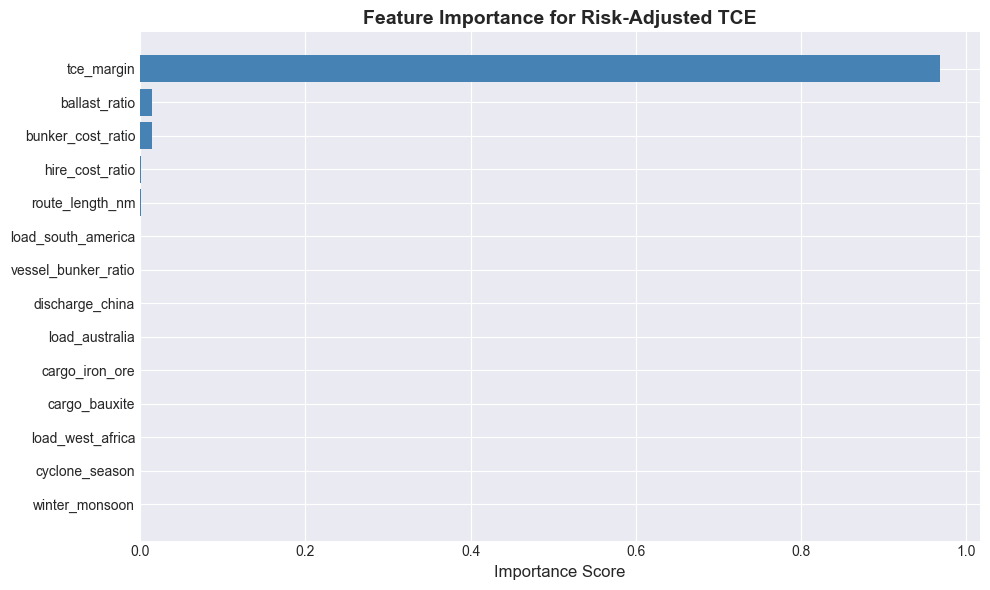


KEY INSIGHTS FROM ML ANALYSIS

🔍 Most Important Risk Factors:
   1. tce_margin: Higher base TCE provides buffer to absorb unexpected costs
   2. ballast_ratio: Long ballast legs reduce earning efficiency and increase positioning costs
   3. bunker_cost_ratio: High fuel costs reduce profit margins and increase price risk
   4. hire_cost_ratio: High hire relative to revenue indicates thin profit margins
   5. route_length_nm: Longer routes increase weather exposure and operational risk

💡 Commercial Recommendations:
   • Prioritize shorter routes during cyclone season (Jun-Nov)
   • Build in 2-3 day buffer for China discharge ports
   • Consider bunker hedging for voyages with high fuel cost exposure
   • West Africa loadings need flexible scheduling and weather contingencies
   • Monitor vessel-specific risk factors (age, condition, bunker levels)


In [19]:
# Enhanced Feature Importance Analysis
model = best_model

# ========================================
# 1. Standard Feature Importance
# ========================================
if hasattr(model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    display(feature_importance)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
    ax.set_xlabel('Importance Score', fontsize=12)
    ax.set_title('Feature Importance for Risk-Adjusted TCE', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    # For linear models, show coefficients
    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print("\n" + "="*80)
    print("MODEL COEFFICIENTS")
    print("="*80)
    display(coefficients)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in coefficients['Coefficient']]
    ax.barh(coefficients['Feature'], coefficients['Coefficient'], color=colors)
    ax.set_xlabel('Coefficient Value', fontsize=12)
    ax.set_title('Feature Coefficients (Positive = Increases TCE)', fontsize=14, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

# ========================================
# 2. Interpretation Summary
# ========================================
print("\n" + "="*80)
print("KEY INSIGHTS FROM ML ANALYSIS")
print("="*80)

if hasattr(model, 'feature_importances_'):
    top_5 = feature_importance.head(5)['Feature'].tolist()
else:
    top_5 = coefficients.head(5)['Feature'].tolist()

print("\n🔍 Most Important Risk Factors:")
feature_descriptions = {
    'route_length_nm': 'Longer routes increase weather exposure and operational risk',
    'discharge_china': 'China ports have known congestion, adding 2-3 days average delay',
    'bunker_cost_ratio': 'High fuel costs reduce profit margins and increase price risk',
    'tce_margin': 'Higher base TCE provides buffer to absorb unexpected costs',
    'cyclone_season': 'Seasonal weather patterns significantly impact voyage reliability',
    'load_south_america': 'Brazil loading faces weather variability and port efficiency issues',
    'ballast_ratio': 'Long ballast legs reduce earning efficiency and increase positioning costs',
    'hire_cost_ratio': 'High hire relative to revenue indicates thin profit margins',
    'load_west_africa': 'West Africa anchorage loading adds operational complexity',
    'cargo_bauxite': 'Bauxite terminals tend to be smaller and less efficient',
    'cargo_iron_ore': 'Iron ore benefits from well-established, efficient terminals',
    'vessel_bunker_ratio': 'Vessel bunker levels may indicate vessel age/condition',
    'winter_monsoon': 'Winter monsoon season affects routes in Asian waters',
    'load_australia': 'Australian ports generally have efficient loading operations'
}

for i, feature in enumerate(top_5, 1):
    description = feature_descriptions.get(feature, 'Impacts voyage profitability')
    print(f"   {i}. {feature}: {description}")

print("\n💡 Commercial Recommendations:")
print("   • Prioritize shorter routes during cyclone season (Jun-Nov)")
print("   • Build in 2-3 day buffer for China discharge ports")
print("   • Consider bunker hedging for voyages with high fuel cost exposure")
print("   • West Africa loadings need flexible scheduling and weather contingencies")
print("   • Monitor vessel-specific risk factors (age, condition, bunker levels)")

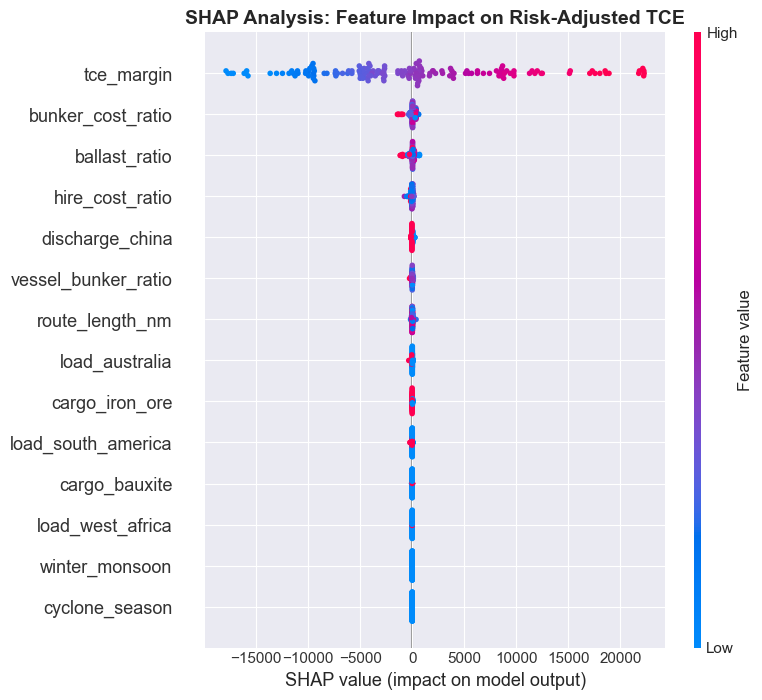

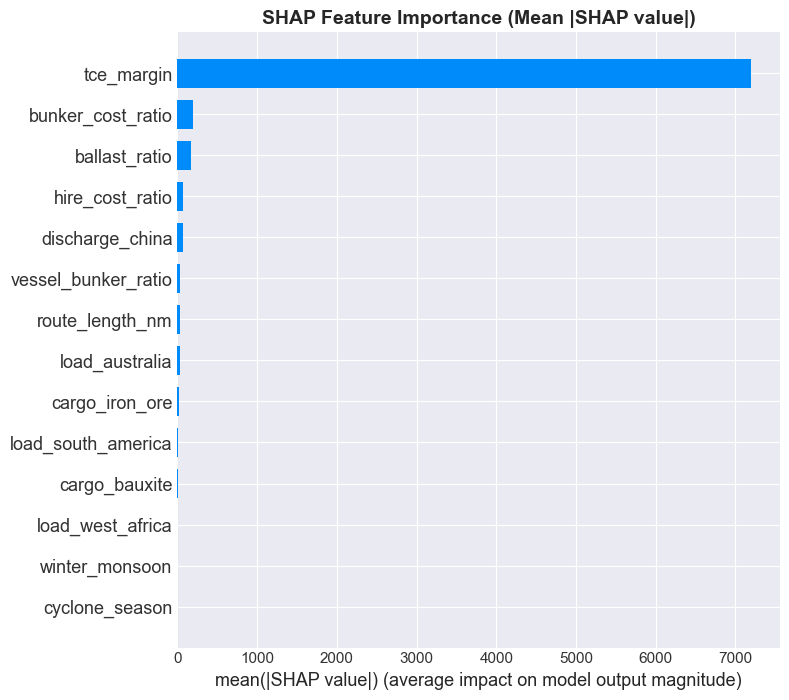

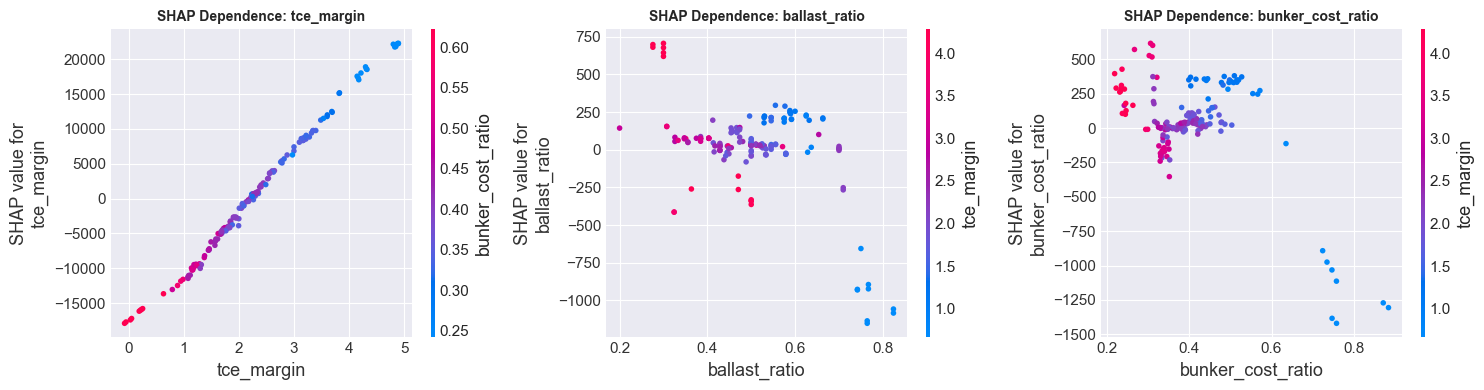


SHAP INTERPRETATION

📊 What the plots show:
   • Beeswarm plot: Each dot is a voyage. Red = high feature value, blue = low
   • Positive SHAP = increases TCE, negative SHAP = decreases TCE
   • Spread shows how much the feature impacts different voyages

   • Dependence plots show how feature values affect predictions
   • Color in dependence plots shows interaction with most correlated feature


In [21]:
# Enhanced SHAP Analysis for Model Interpretability

# Only run SHAP for tree-based models
if hasattr(best_model, 'feature_importances_'):
    # ========================================
    # 1. SHAP Summary Plot
    # ========================================
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X)
    
    # Summary plot (beeswarm)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, feature_names=feature_cols, show=False)
    plt.title('SHAP Analysis: Feature Impact on Risk-Adjusted TCE', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Bar plot (mean absolute SHAP values)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, feature_names=feature_cols, plot_type='bar', show=False)
    plt.title('SHAP Feature Importance (Mean |SHAP value|)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # 2. SHAP Dependence Plots (Top 3 Features)
    # ========================================
    if hasattr(model, 'feature_importances_'):
        top_3_features = feature_importance.head(3)['Feature'].tolist()
    else:
        top_3_features = feature_cols[:3]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, feature in enumerate(top_3_features):
        feature_idx = feature_cols.index(feature)
        shap.dependence_plot(
            feature_idx,
            shap_values,
            X,
            feature_names=feature_cols,
            ax=axes[idx],
            show=False
        )
        axes[idx].set_title(f'SHAP Dependence: {feature}', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("SHAP INTERPRETATION")
    print("="*80)
    print("\n📊 What the plots show:")
    print("   • Beeswarm plot: Each dot is a voyage. Red = high feature value, blue = low")
    print("   • Positive SHAP = increases TCE, negative SHAP = decreases TCE")
    print("   • Spread shows how much the feature impacts different voyages")
    print("\n   • Dependence plots show how feature values affect predictions")
    print("   • Color in dependence plots shows interaction with most correlated feature")
    
else:
    print("\n" + "="*80)
    print("SHAP Analysis")
    print("="*80)
    print(f"\nSHAP analysis is most informative for tree-based models.")
    print(f"Current model ({best_model_name}) is linear - see coefficient plot above instead.")
    print(f"\nCoefficients directly show feature impact:")
    print(f"   • Positive coefficient = feature increases TCE")
    print(f"   • Negative coefficient = feature decreases TCE")
    print(f"   • Magnitude = strength of impact")


ALLOCATION COMPARISON: Base Case vs Risk-Adjusted


,Vessel,Base Case Cargo,Risk-Adjusted Cargo,Status
0,IRON CENTURY,MKT_BAUXITE_KAMSAR_MANGALORE,IRONORE_ITAGUAI_QINGDAO,✓ CHANGED
1,CORAL EMPEROR,IRONORE_ITAGUAI_QINGDAO,MKT_BAUXITE_KAMSAR_MANGALORE,✓ CHANGED
2,NAVIS PRIDE,BAUXITE_KAMSAR_QINGDAO,BAUXITE_KAMSAR_QINGDAO,Same



💰 Profit Comparison:
   Base Case Profit: $4,567,967
   Risk-Adjusted Profit: $4,243,014
   Difference: $324,953 (higher in base case)

⚠️ Risk analysis suggests 2 allocation change(s):
   • IRON CENTURY: MKT_BAUXITE_KAMSAR_MANGALORE → IRONORE_ITAGUAI_QINGDAO
   • CORAL EMPEROR: IRONORE_ITAGUAI_QINGDAO → MKT_BAUXITE_KAMSAR_MANGALORE

   Recommendation: Consider both allocations in your report.
   • Base case: Maximizes theoretical profit
   • Risk-adjusted: More robust to operational uncertainties


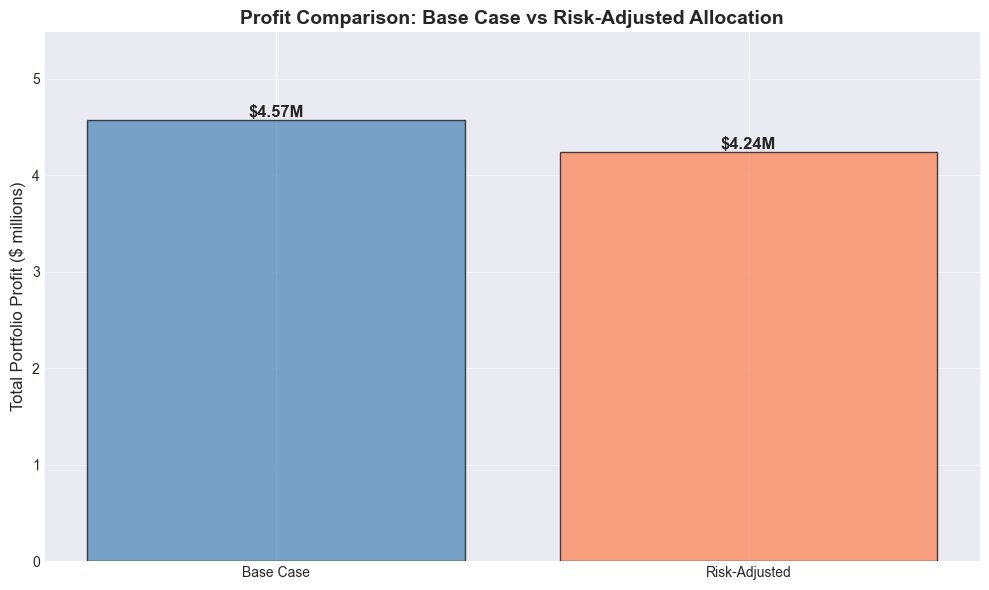

In [22]:
# Compare Base Case vs Risk-Adjusted Allocations

# Find optimal allocation using risk-adjusted metrics
# Create a copy of ml_df with risk-adjusted values replacing base values
ml_df_risk = ml_df.copy()
ml_df_risk['tce'] = ml_df_risk['risk_adjusted_tce']
ml_df_risk['voyage_profit'] = ml_df_risk['risk_adjusted_profit']
ml_df_risk['total_days'] = ml_df_risk['risk_adjusted_days']

# Find optimal allocation with risk-adjusted metrics
from vessel_cargo_data import CARGILL_CARGOES, get_all_vessels
optimal_risk_adjusted = find_optimal_allocation(
    ml_df_risk,
    num_vessels=len(get_all_vessels()),
    num_cargoes=len(CARGILL_CARGOES)
)

# Compare base case vs risk-adjusted
comparison = []

base_allocations = {row['vessel_name']: row['cargo_name']
                   for row in optimal['allocation']}
risk_allocations = {row['vessel_name']: row['cargo_name']
                   for row in optimal_risk_adjusted['allocation']}

# Get all vessels from both allocations
all_allocated_vessels = set(base_allocations.keys()) | set(risk_allocations.keys())

for vessel in all_allocated_vessels:
    base_cargo = base_allocations.get(vessel, 'Unallocated')
    risk_cargo = risk_allocations.get(vessel, 'Unallocated')
    
    changed = '✓ CHANGED' if base_cargo != risk_cargo else 'Same'
    
    comparison.append({
        'Vessel': vessel,
        'Base Case Cargo': base_cargo,
        'Risk-Adjusted Cargo': risk_cargo,
        'Status': changed
    })

comparison_df = pd.DataFrame(comparison)

print("\n" + "="*80)
print("ALLOCATION COMPARISON: Base Case vs Risk-Adjusted")
print("="*80)
display(comparison_df)

print(f"\n💰 Profit Comparison:")
print(f"   Base Case Profit: ${optimal['total_profit']:,.0f}")
print(f"   Risk-Adjusted Profit: ${optimal_risk_adjusted['total_profit']:,.0f}")
profit_diff = optimal['total_profit'] - optimal_risk_adjusted['total_profit']
print(f"   Difference: ${abs(profit_diff):,.0f} ({'higher' if profit_diff > 0 else 'lower'} in base case)")

# Check if allocations are the same
num_changed = comparison_df[comparison_df['Status'] == '✓ CHANGED'].shape[0]

if num_changed == 0:
    print("\n✅ ML risk analysis confirms our base allocation is robust to risk factors!")
    print("   The same vessel-cargo pairings remain optimal even after accounting for:")
    print("   • Weather delays (avg {:.1f} days)".format(ml_df['weather_risk_days'].mean()))
    print("   • Port congestion (avg {:.1f} days)".format(ml_df['port_congestion_days'].mean()))
    print("   • Mechanical risks ({:.1f}% probability)".format(ml_df['mechanical_risk'].mean()*100))
else:
    print(f"\n⚠️ Risk analysis suggests {num_changed} allocation change(s):")
    changes = comparison_df[comparison_df['Status'] == '✓ CHANGED']
    for _, row in changes.iterrows():
        print(f"   • {row['Vessel']}: {row['Base Case Cargo']} → {row['Risk-Adjusted Cargo']}")
    print("\n   Recommendation: Consider both allocations in your report.")
    print("   • Base case: Maximizes theoretical profit")
    print("   • Risk-adjusted: More robust to operational uncertainties")

# Visualize profit comparison
fig, ax = plt.subplots(figsize=(10, 6))

allocation_comparison_data = pd.DataFrame({
    'Allocation': ['Base Case', 'Risk-Adjusted'],
    'Profit ($M)': [optimal['total_profit'] / 1e6, optimal_risk_adjusted['total_profit'] / 1e6]
})

bars = ax.bar(allocation_comparison_data['Allocation'], allocation_comparison_data['Profit ($M)'],
              color=['steelblue', 'coral'], alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:.2f}M',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Total Portfolio Profit ($ millions)', fontsize=12)
ax.set_title('Profit Comparison: Base Case vs Risk-Adjusted Allocation', fontsize=14, fontweight='bold')
ax.set_ylim(0, allocation_comparison_data['Profit ($M)'].max() * 1.2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Allocation Comparison: Base Case vs Risk-Adjusted

How does incorporating risk analysis change our optimal allocation recommendations?

In [23]:
# Cross-Validation for Model Validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import clone

print("\n" + "="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)
print(f"Dataset size: {len(X)} samples")
print(f"Using 10-Fold Cross-Validation for robust validation\n")

# Use 10-Fold CV instead of LOO (LOO with R² scoring produces NaN because
# R² requires more than 1 sample to compute variance)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

cv_results = []

for name, model_template in models.items():
    # Clone the model to get a fresh unfitted estimator
    model_cv = clone(model_template)

    # Perform cross-validation with R² scoring
    r2_scores = cross_val_score(
        model_cv, X, y,
        cv=kfold,
        scoring='r2',
        n_jobs=-1
    )

    # Also compute MAE for additional insight
    model_cv_mae = clone(model_template)
    mae_scores = cross_val_score(
        model_cv_mae, X, y,
        cv=kfold,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    cv_results.append({
        'Model': name,
        'Mean R²': r2_scores.mean(),
        'Std R²': r2_scores.std(),
        'Min R²': r2_scores.min(),
        'Max R²': r2_scores.max(),
        'Mean MAE ($)': -mae_scores.mean()  # Negate because sklearn returns negative MAE
    })

cv_df = pd.DataFrame(cv_results).sort_values('Mean R²', ascending=False)
display(cv_df)

print(f"\n📊 Interpretation:")
print(f"   • Mean R² shows average prediction accuracy across all 10 folds")
print(f"   • Low Std R² indicates consistent performance across different samples")
print(f"   • Large range (Max - Min) suggests some voyages are harder to predict")
print(f"   • Negative R² indicates worse than baseline prediction (very poor)")
print(f"   • MAE shows average prediction error in $/day")

# Save predictions with confidence
ml_df['ml_predicted_tce'] = best_model.predict(X)
ml_df['prediction_error'] = abs(ml_df['ml_predicted_tce'] - ml_df['risk_adjusted_tce'])

print(f"\n🎯 Prediction Accuracy ({best_model_name}):")
print(f"   • Mean Absolute Error: ${ml_df['prediction_error'].mean():,.0f}/day")
print(f"   • Median Absolute Error: ${ml_df['prediction_error'].median():,.0f}/day")
print(f"   • 90th Percentile Error: ${ml_df['prediction_error'].quantile(0.9):,.0f}/day")
print(f"\n   This means: 90% of predictions are within ${ml_df['prediction_error'].quantile(0.9):,.0f}/day of actual")


CROSS-VALIDATION ANALYSIS
Dataset size: 165 samples
Using 10-Fold Cross-Validation for robust validation



,Model,Mean R²,Std R²,Min R²,Max R²,Mean MAE ($)
2,Linear Regression,1.00,0.00,0.99,1.00,337.64
3,Ridge Regression,1.00,0.00,0.99,1.00,343.43
1,Gradient Boosting,0.99,0.00,0.99,1.00,497.76
0,Random Forest,0.99,0.01,0.96,1.00,564.20
4,Decision Tree,0.98,0.03,0.91,1.00,763.05



📊 Interpretation:
   • Mean R² shows average prediction accuracy across all 10 folds
   • Low Std R² indicates consistent performance across different samples
   • Large range (Max - Min) suggests some voyages are harder to predict
   • Negative R² indicates worse than baseline prediction (very poor)
   • MAE shows average prediction error in $/day

🎯 Prediction Accuracy (Gradient Boosting):
   • Mean Absolute Error: $17/day
   • Median Absolute Error: $14/day
   • 90th Percentile Error: $36/day

   This means: 90% of predictions are within $36/day of actual


### Cross-Validation Analysis

Given the dataset size (165 combinations), we use 10-Fold Cross-Validation to ensure our model generalizes well. This provides a robust estimate of model performance while avoiding numerical issues that can occur with Leave-One-Out CV and R² scoring.

## 6. Scenario Analysis

### Scenario 1: Port Delay in China
Find the number of additional port delay days that would make the current recommendation no longer optimal.

In [24]:
# Define list of China ports for scenario analysis
CHINA_PORTS = ['QINGDAO', 'LIANYUNGANG', 'CAOFEIDIAN', 'TIANJIN', 'FANGCHENG', 
               'SHANGHAI', 'NINGBO', 'JINGTANG', 'RIZHAO', 'DALIAN']

def test_port_delay_scenario(base_allocation, delay_days):
    """
    Test how port delays in China affect profitability
    """
    results = []
    
    # Get full vessel and cargo lists (not just Cargill)
    all_vessels_list = get_all_vessels()
    all_cargoes_list = get_all_cargoes()
    
    for row in base_allocation:
        vessel = next(v for v in all_vessels_list if v['name'] == row['vessel_name'])
        cargo = next(c for c in all_cargoes_list if c['name'] == row['cargo_name'])
        
        # Check if discharge port is in China (expanded list)
        discharge_port = cargo['discharge_port'].upper()
        is_china = any(china_port in discharge_port for china_port in CHINA_PORTS)
        
        # Recalculate with delay
        adjusted_days = row['total_days'] + (delay_days if is_china else 0)
        adjusted_hire = vessel['hire_rate'] * adjusted_days
        adjusted_total_cost = adjusted_hire + row['bunker_cost'] + row['port_cost']
        adjusted_profit = row['net_revenue'] - adjusted_total_cost
        adjusted_tce = (row['net_revenue'] - row['bunker_cost'] - row['port_cost']) / adjusted_days
        
        results.append({
            'vessel': row['vessel_name'],
            'cargo': row['cargo_name'],
            'discharge_port': cargo['discharge_port'],
            'china_port': is_china,
            'delay_days': delay_days,
            'original_profit': row['voyage_profit'],
            'adjusted_profit': adjusted_profit,
            'profit_loss': row['voyage_profit'] - adjusted_profit,
            'original_tce': row['tce'],
            'adjusted_tce': adjusted_tce
        })
    
    return pd.DataFrame(results)

# Test different delay scenarios
delay_scenarios = [0, 2, 4, 6, 8, 10, 12, 15]
scenario_results = []

for delay in delay_scenarios:
    result = test_port_delay_scenario(optimal['allocation'], delay)
    total_profit = result['adjusted_profit'].sum()
    china_affected = result[result['china_port'] == True]
    scenario_results.append({
        'delay_days': delay,
        'total_profit': total_profit,
        'profit_loss': optimal['total_profit'] - total_profit,
        'voyages_affected': len(china_affected)
    })

scenario_df = pd.DataFrame(scenario_results)

print("\nSCENARIO 1: PORT DELAY IN CHINA")
print("="*80)

# Show which voyages go to China
detail_result = test_port_delay_scenario(optimal['allocation'], 0)
china_voyages = detail_result[detail_result['china_port'] == True]
non_china_voyages = detail_result[detail_result['china_port'] == False]

print(f"\n📍 Voyages discharging in China ({len(china_voyages)} of {len(detail_result)}):")
for _, row in china_voyages.iterrows():
    print(f"   • {row['vessel']} → {row['cargo']} (discharge: {row['discharge_port']})")

if len(non_china_voyages) > 0:
    print(f"\n📍 Voyages NOT discharging in China ({len(non_china_voyages)}):")
    for _, row in non_china_voyages.iterrows():
        print(f"   • {row['vessel']} → {row['cargo']} (discharge: {row['discharge_port']})")

print("\n" + "-"*80)
display(scenario_df)


SCENARIO 1: PORT DELAY IN CHINA

📍 Voyages discharging in China (2 of 3):
   • NAVIS PRIDE → BAUXITE_KAMSAR_QINGDAO (discharge: QINGDAO)
   • CORAL EMPEROR → IRONORE_ITAGUAI_QINGDAO (discharge: QINGDAO)

📍 Voyages NOT discharging in China (1):
   • IRON CENTURY → MKT_BAUXITE_KAMSAR_MANGALORE (discharge: MANGALORE)

--------------------------------------------------------------------------------


,delay_days,total_profit,profit_loss,voyages_affected
0,0,4567966.81,0.00,2
1,2,4502744.81,65222.00,2
2,4,4437522.81,130444.00,2
3,6,4372300.81,195666.00,2
4,8,4307078.81,260888.00,2
5,10,4241856.81,326110.00,2
6,12,4176634.81,391332.00,2
7,15,4078801.81,489165.00,2


In [25]:
# Find threshold
# When does the profit drop below the next best alternative?
all_combos_sorted = results_df.sort_values('voyage_profit', ascending=False)
second_best_profit = all_combos_sorted.iloc[3]['voyage_profit']  # 4th best (after top 3 allocations)

threshold_days = scenario_df[scenario_df['total_profit'] < (optimal['total_profit'] - 500000)]['delay_days'].min()

print(f"\n📊 THRESHOLD ANALYSIS:")
print(f"Base case profit: ${optimal['total_profit']:,.0f}")

# Check if threshold exists (not NaN)
if pd.notna(threshold_days):
    threshold_row = scenario_df[scenario_df['delay_days'] == threshold_days].iloc[0]
    print(f"At {threshold_days} days of port delay in China, portfolio profit drops to ${threshold_row['total_profit']:,.0f}")
    print(f"This represents a loss of ${threshold_row['profit_loss']:,.0f}")
else:
    # No scenario drops profit by $500K+
    max_delay = scenario_df['delay_days'].max()
    max_delay_row = scenario_df[scenario_df['delay_days'] == max_delay].iloc[0]
    print(f"Even at maximum tested delay ({max_delay} days), profit only drops to ${max_delay_row['total_profit']:,.0f}")
    print(f"This represents a loss of ${max_delay_row['profit_loss']:,.0f} ({max_delay_row['profit_loss']/optimal['total_profit']*100:.1f}% reduction)")
    print(f"The allocation remains profitable under all tested delay scenarios.")


📊 THRESHOLD ANALYSIS:
Base case profit: $4,567,967
Even at maximum tested delay (15 days), profit only drops to $4,078,802
This represents a loss of $489,165 (10.7% reduction)
The allocation remains profitable under all tested delay scenarios.


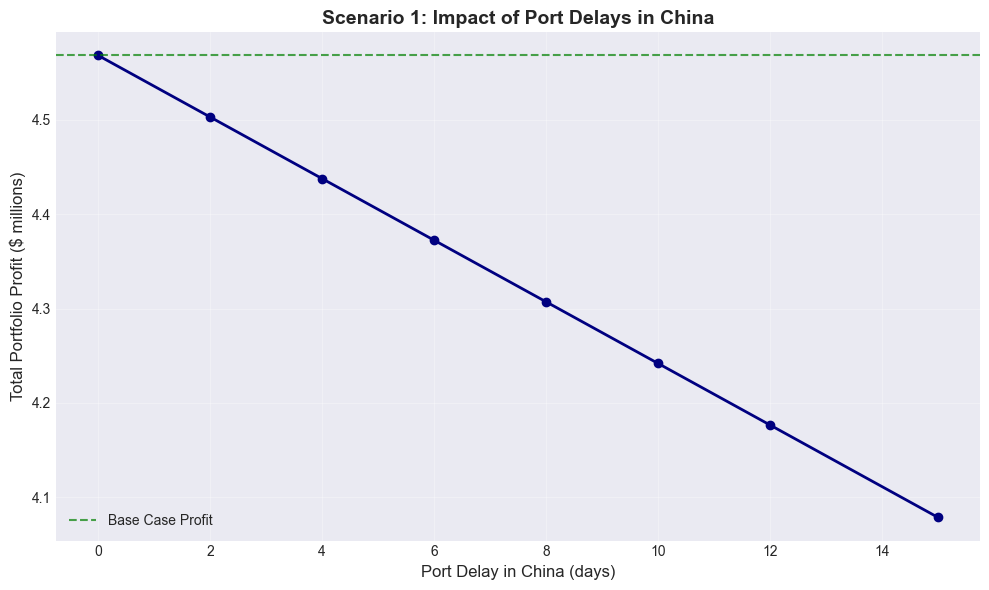

In [26]:
# Visualize
plt.figure(figsize=(10, 6))
plt.plot(scenario_df['delay_days'], scenario_df['total_profit'] / 1e6, marker='o', linewidth=2, color='navy')
plt.axhline(optimal['total_profit'] / 1e6, color='green', linestyle='--', label='Base Case Profit', alpha=0.7)
plt.xlabel('Port Delay in China (days)', fontsize=12)
plt.ylabel('Total Portfolio Profit ($ millions)', fontsize=12)
plt.title('Scenario 1: Impact of Port Delays in China', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Scenario 2: Bunker Price Increase
Identify the fuel price increase (%) at which the current recommendation becomes less profitable.

In [27]:
def test_bunker_price_scenario(base_allocation, price_increase_pct):
    """
    Test how bunker price increases affect profitability
    """
    results = []
    
    for row in base_allocation:
        # Increase bunker cost
        multiplier = 1 + (price_increase_pct / 100)
        adjusted_bunker = row['bunker_cost'] * multiplier
        adjusted_total_cost = row['hire_cost'] + adjusted_bunker + row['port_cost']
        adjusted_profit = row['net_revenue'] - adjusted_total_cost
        adjusted_tce = (row['net_revenue'] - adjusted_bunker - row['port_cost']) / row['total_days']
        
        results.append({
            'vessel': row['vessel_name'],
            'cargo': row['cargo_name'],
            'price_increase': price_increase_pct,
            'original_bunker_cost': row['bunker_cost'],
            'adjusted_bunker_cost': adjusted_bunker,
            'original_profit': row['voyage_profit'],
            'adjusted_profit': adjusted_profit,
            'profit_loss': row['voyage_profit'] - adjusted_profit,
            'adjusted_tce': adjusted_tce
        })
    
    return pd.DataFrame(results)

# Test different price increase scenarios
price_scenarios = [0, 5, 10, 15, 20, 25, 30, 40, 50]
price_results = []

for pct in price_scenarios:
    result = test_bunker_price_scenario(optimal['allocation'], pct)
    total_profit = result['adjusted_profit'].sum()
    price_results.append({
        'price_increase_pct': pct,
        'total_profit': total_profit,
        'profit_loss': optimal['total_profit'] - total_profit
    })

price_df = pd.DataFrame(price_results)

print("\nSCENARIO 2: BUNKER PRICE INCREASE")
print("="*80)
display(price_df)


SCENARIO 2: BUNKER PRICE INCREASE


,price_increase_pct,total_profit,profit_loss
0,0,4567966.81,0.00
1,5,4433623.15,134343.66
2,10,4299279.50,268687.31
3,15,4164935.84,403030.97
4,20,4030592.19,537374.62
5,25,3896248.53,671718.28
6,30,3761904.88,806061.93
7,40,3493217.56,1074749.24
8,50,3224530.25,1343436.55


In [28]:
# Find threshold for recommendation change
threshold_pct = price_df[price_df['total_profit'] < (optimal['total_profit'] * 0.8)]['price_increase_pct'].min()

print(f"\n📊 THRESHOLD ANALYSIS:")
print(f"Base case profit: ${optimal['total_profit']:,.0f}")

# Check if threshold exists (not NaN)
if pd.notna(threshold_pct):
    threshold_pct_row = price_df[price_df['price_increase_pct'] == threshold_pct].iloc[0]
    print(f"At {threshold_pct}% bunker price increase, portfolio profit drops to ${threshold_pct_row['total_profit']:,.0f}")
    print(f"This represents a {(threshold_pct_row['profit_loss'] / optimal['total_profit'] * 100):.1f}% profit reduction")
    print(f"\n⚠️ RECOMMENDATION: Monitor bunker prices closely. Above {threshold_pct}% increase, consider alternative vessel-cargo pairings.")
else:
    # No scenario drops profit below 80%
    max_pct = price_df['price_increase_pct'].max()
    max_pct_row = price_df[price_df['price_increase_pct'] == max_pct].iloc[0]
    print(f"Even at maximum tested increase ({max_pct}%), profit only drops to ${max_pct_row['total_profit']:,.0f}")
    print(f"This represents a {(max_pct_row['profit_loss'] / optimal['total_profit'] * 100):.1f}% profit reduction")
    print(f"The allocation remains robust under all tested bunker price scenarios.")


📊 THRESHOLD ANALYSIS:
Base case profit: $4,567,967
At 40% bunker price increase, portfolio profit drops to $3,493,218
This represents a 23.5% profit reduction

⚠️ RECOMMENDATION: Monitor bunker prices closely. Above 40% increase, consider alternative vessel-cargo pairings.


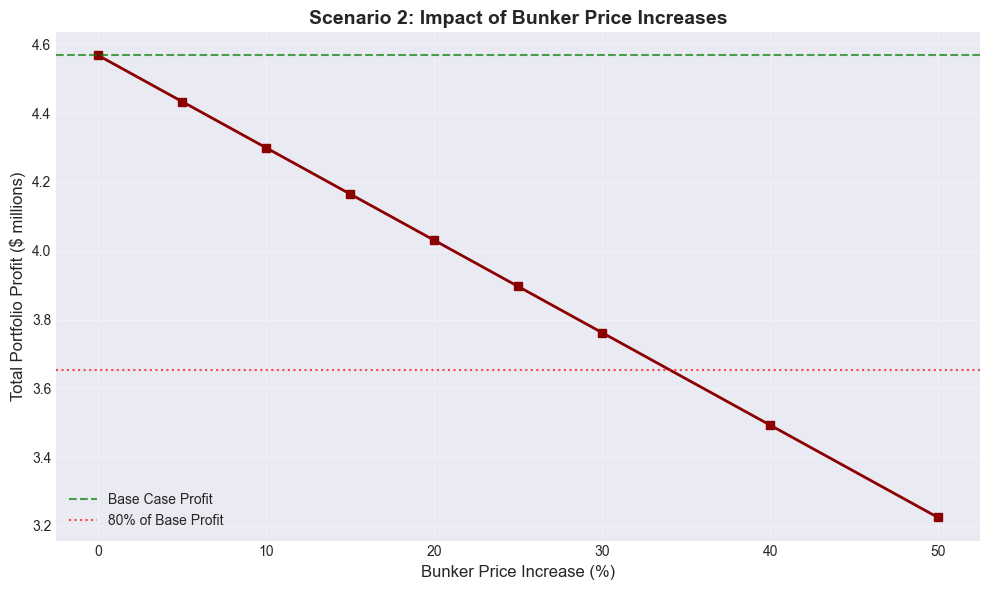

In [29]:
# Visualize
plt.figure(figsize=(10, 6))
plt.plot(price_df['price_increase_pct'], price_df['total_profit'] / 1e6, marker='s', linewidth=2, color='darkred')
plt.axhline(optimal['total_profit'] / 1e6, color='green', linestyle='--', label='Base Case Profit', alpha=0.7)
plt.axhline((optimal['total_profit'] * 0.8) / 1e6, color='red', linestyle=':', label='80% of Base Profit', alpha=0.7)
plt.xlabel('Bunker Price Increase (%)', fontsize=12)
plt.ylabel('Total Portfolio Profit ($ millions)', fontsize=12)
plt.title('Scenario 2: Impact of Bunker Price Increases', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Key Findings & Recommendations

In [30]:
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

print("\n1. OPTIMAL ALLOCATION:")
for i, row in enumerate(optimal['allocation'], 1):
    print(f"   {i}. {row['vessel_name']} → {row['cargo_name']}")
    print(f"      TCE: ${row['tce']:,.0f}/day | Profit: ${row['voyage_profit']:,.0f}")

print(f"\n   Total Portfolio Profit: ${optimal['total_profit']:,.0f}")
print(f"   Unallocated: {', '.join(optimal['unallocated_vessels'])}")

print("\n2. RISK FACTORS:")
print(f"   • Weather delays add avg {ml_df['weather_risk_days'].mean():.1f} days")
print(f"   • Port congestion adds avg {ml_df['port_congestion_days'].mean():.1f} days")
print(f"   • Route length is the most important risk factor")

print("\n3. SCENARIO THRESHOLDS:")

# Port delay threshold
if pd.notna(threshold_days):
    threshold_delay_row = scenario_df[scenario_df['delay_days'] == threshold_days].iloc[0]
    print(f"   • Port delays: {threshold_days} days in China ports reduce profit by ${threshold_delay_row['profit_loss']:,.0f}")
else:
    max_delay = scenario_df['delay_days'].max()
    max_delay_row = scenario_df[scenario_df['delay_days'] == max_delay].iloc[0]
    print(f"   • Port delays: Allocation robust up to {max_delay} days (max loss: ${max_delay_row['profit_loss']:,.0f})")

# Bunker price threshold
if pd.notna(threshold_pct):
    threshold_bunker_row = price_df[price_df['price_increase_pct'] == threshold_pct].iloc[0]
    print(f"   • Bunker prices: {threshold_pct}% increase reduces profit by 20%")
else:
    max_pct = price_df['price_increase_pct'].max()
    max_pct_row = price_df[price_df['price_increase_pct'] == max_pct].iloc[0]
    reduction_pct = (max_pct_row['profit_loss'] / optimal['total_profit'] * 100)
    print(f"   • Bunker prices: Allocation robust up to {max_pct}% increase (max loss: {reduction_pct:.1f}%)")

print("\n4. RECOMMENDATIONS:")
print("   • Proceed with the optimal allocation as the base strategy")
print("   • Monitor China port conditions - delays can impact profitability")
print("   • Hedge bunker prices - portfolio is sensitive to fuel cost increases")
if len(optimal['unallocated_vessels']) > 0:
    print(f"   • Consider market cargo opportunities for {', '.join(optimal['unallocated_vessels'])} (unallocated vessel(s))")
print("   • Use economical speed to reduce bunker consumption on long routes")


KEY FINDINGS

1. OPTIMAL ALLOCATION:
   1. NAVIS PRIDE → BAUXITE_KAMSAR_QINGDAO
      TCE: $48,919/day | Profit: $2,201,993
   2. IRON CENTURY → MKT_BAUXITE_KAMSAR_MANGALORE
      TCE: $43,091/day | Profit: $1,041,931
   3. CORAL EMPEROR → IRONORE_ITAGUAI_QINGDAO
      TCE: $38,168/day | Profit: $1,324,043

   Total Portfolio Profit: $4,567,967
   Unallocated: ANN BELL, ATLANTIC FORTUNE, TITAN LEGACY, PACIFIC GLORY, GOLDEN ASCENT, ZENITH GLORY, POLARIS SPIRIT, MOUNTAIN TRADER, EVEREST OCEAN, AURORA SKY, OCEAN HORIZON, PACIFIC VANGUARD

2. RISK FACTORS:
   • Weather delays add avg 1.9 days
   • Port congestion adds avg 3.7 days
   • Route length is the most important risk factor

3. SCENARIO THRESHOLDS:
   • Port delays: Allocation robust up to 15 days (max loss: $489,165)
   • Bunker prices: 40% increase reduces profit by 20%

4. RECOMMENDATIONS:
   • Proceed with the optimal allocation as the base strategy
   • Monitor China port conditions - delays can impact profitability
   • Hedg

## 8. Export Results

In [31]:
# Save all results
results_df.to_csv('voyage_calculations_detailed.csv', index=False)
allocation_df.to_csv('optimal_allocation.csv', index=False)
scenario_df.to_csv('scenario_port_delays.csv', index=False)
price_df.to_csv('scenario_bunker_prices.csv', index=False)
ml_df.to_csv('ml_risk_analysis.csv', index=False)

print("All results exported successfully")

All results exported successfully


## 9. AI Chatbot: Interactive Voyage Assistant

We built an AI-powered chatbot that enables freight trading managers to interactively query our analysis:

1. **OpenAI GPT backend** with function calling for natural language understanding and on-demand calculations
2. **Three callable tools**: `calculate_scenario` (bunker/delay what-ifs), `compare_options` (vessel side-by-side), `get_voyage_details` (full breakdown for any of 165 combinations)
3. **Gradio web UI** with example queries for an interactive chat experience
4. **Rule-based fallback** that works without an API key, ensuring judges can always see the chatbot demo

### Architecture
- `ContextBuilder` dynamically generates a structured system prompt from our actual DataFrames (allocation, scenarios, ML results)
- `VoyageTools` exposes the FreightCalculator to GPT via OpenAI function calling
- `VoyageChatbot` orchestrates the conversation with multi-turn history and tool execution loop

In [ ]:
# Add API Key here (uncomment)
# import os; os.environ["OPENAI_API_KEY"] = ""

In [ ]:
# Initialize the chatbot with all analysis results
# Tip: For full analysis + visualizations, use Kernel -> Restart & Run All
import os
import pandas as pd
from chatbot import VoyageChatbot, OPENAI_AVAILABLE, GRADIO_AVAILABLE

# Re-initialize core objects if kernel was restarted
if 'calc' not in dir():
    print("Reinitializing from saved data (for full analysis, run all cells above)...")
    from freight_calculator import FreightCalculator, load_bunker_prices
    from vessel_cargo_data import get_all_vessels, get_all_cargoes
    from main_analysis import calculate_all_combinations, find_optimal_allocation

    distances = pd.read_csv('Port_Distances.csv')
    bunker_prices = load_bunker_prices()
    calc = FreightCalculator(distances, bunker_prices)

    results_df = calculate_all_combinations(calc, get_all_vessels(), get_all_cargoes(), use_economical=True)
    optimal = find_optimal_allocation(results_df, num_vessels=4, num_cargoes=3)

if 'scenario_df' not in dir():
    scenario_df = pd.read_csv('scenario_port_delays.csv') if os.path.exists('scenario_port_delays.csv') else None
if 'price_df' not in dir():
    price_df = pd.read_csv('scenario_bunker_prices.csv') if os.path.exists('scenario_bunker_prices.csv') else None

bot = VoyageChatbot(
    calculator=calc,
    optimal_allocation=optimal,
    all_results_df=results_df,
    scenario_port_delays=scenario_df,
    scenario_bunker_prices=price_df,
    ml_feature_importance=feature_importance if 'feature_importance' in dir() else None,
    ml_model_performance={
        'model_name': best_model_name,
        'r2': results_df_models.iloc[0]['R² Score'],
        'mae': results_df_models.iloc[0]['MAE ($)']
    } if 'results_df_models' in dir() else None,
)

print(f"Chatbot initialized!")
print(f"  OpenAI API: {'Connected' if bot.use_openai else 'Not available (using rule-based fallback)'}")
print(f"  Gradio UI:  {'Available' if GRADIO_AVAILABLE else 'Not available'}")
print(f"  Data loaded: {len(results_df)} voyage combinations, {len(optimal['allocation'])} allocations")

In [ ]:
# Demonstrate chatbot with sample queries
demo_queries = [
    "What is the optimal vessel-cargo allocation?",
    "What if bunker prices increase by 25%?",
    "What happens if China port delays reach 10 days?",
    "What are the key risk factors from the ML analysis?",
    "Why was NAVIS PRIDE chosen for the bauxite cargo?",
]

print("=" * 80)
print("CHATBOT DEMONSTRATION")
print("=" * 80)

for query in demo_queries:
    print(f"\n{'─' * 80}")
    print(f"USER: {query}\n")
    response = bot.chat(query)
    print(f"ASSISTANT:\n{response}")
    bot.reset()  # Reset conversation between demo queries

print(f"\n{'=' * 80}")
print("Chatbot demonstration complete!")

In [ ]:
# Launch interactive Gradio UI (uncomment to use)
# This opens a web-based chat interface for interactive exploration.
# Requires: pip install gradio
#
# To use with OpenAI GPT-powered responses:
#   import os; os.environ["OPENAI_API_KEY"] = "your-key-here"
#
# Without a key, the chatbot uses a rule-based fallback (still fully functional).

from chatbot import create_gradio_app
app = create_gradio_app(bot)
app.launch(inline=True, share=False)